In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import *

In [3]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [4]:
pd.set_option('display.max_columns', 150)
pd.options.mode.chained_assignment = None  # default='warn'

In [5]:
path = 'data/'

## Target variable

Target variable ```caseAtVisit``` indicates whether patients suffered VTE during the monitoring period:
- ```caseAtVisit==0```: VTE at 0 months
- ```caseAtVisit==1```: VTE at 6 months
- ```caseAtVisit==2```: VTE at 12 months
- ```caseAtVisit==3```: VTE at 18 months
- ```caseAtVisit==NaN```: No VTE

Here we consider ```y=1``` if the patient suffered an VTE within the first 6 months (```caseAtVisit==0``` or ```caseAtVisit==1```) and ```y=0``` elsewhere.

## 1) Considering selected clinical-genetic variables (table 3)

<img src="images/table3.png" alt="" width="400"/>

- I have considered *lung* as high risk ```HR``` tumour site and *stomach, pancreas* as very high risk ```VHR``` sites.
- ```Tumour stage``` is 1 for stage 4 tumours and 0 elsewhere.

### 1.1) Only rows where ```excluido==0```

There is 1 missing value in ```rs2232698``` which is replaced by 'CC'.

In [6]:
data = pd.read_csv(path + 'data_TiC_Onco.csv')
X = data[data.columns.difference(['id','excluido','VTE','khorana'])]
y = data['VTE']
khorana = data['khorana']

X.shape, y.shape

((391, 9), (391,))

In [7]:
X.head()

,Family,bmi,estadiGrup,rs2232698,rs4524,rs5985,rs6025,tipusTumor_HR,tipusTumor_VHR
0,0,1,1,0,1,1,0,0,0
1,0,0,0,0,1,0,0,0,1
2,0,0,1,0,2,0,0,1,0
3,0,0,1,0,2,0,0,0,0
4,0,1,1,0,2,0,0,0,0


In [8]:
y.value_counts() # should be 320, 71

0    318
1     73
Name: VTE, dtype: int64

In [9]:
print_summary(X,y)


                      Variable  VTE (n)  VTE (%)  No-VTE (n)  No-VTE (%)
0                       Family        6      8.2          12         3.8
1                          bmi       37     50.7         145        45.6
2                 estadiGrup I       49     67.1         132        41.5
3                estadiGrup II        0      0.0           0         0.0
4               estadiGrup III        0      0.0           0         0.0
5                estadiGrup IV        0      0.0           0         0.0
6   rs2232698 - 0 risk alleles       69     94.5         313        98.4
7    rs2232698 - 1 risk allele        4      5.5           5         1.6
8      rs4524 - 0 risk alleles        1      1.4          22         6.9
9       rs4524 - 1 risk allele       23     31.5         114        35.8
10     rs4524 - 2 risk alleles       49     67.1         182        57.2
11     rs5985 - 0 risk alleles       38     52.1         182        57.2
12      rs5985 - 1 risk allele       30     41.1  

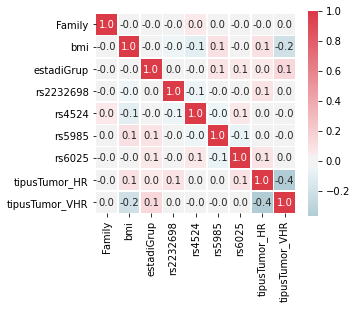

In [10]:
corr_heatmap(X, figsize=(5,5))

### Khorana score

In [12]:
test_khorana(khorana, y)

AUC:  52.68
Accuracy (%): 71.1
Sensivity (%): 23.29
Specificity (%): 82.08
PPV (%): 22.97
NPV (%): 82.33


In [27]:
test_khorana_bootstrap(khorana, y)

,score,mean,95% CI
0,AUC,0.53,"(0.47,0.58)"
1,accuracy,0.71,"(0.67,0.76)"
2,sensitivity,0.23,"(0.13,0.33)"
3,specificity,0.82,"(0.78,0.86)"
4,PPV,0.23,"(0.13,0.32)"
5,NPV,0.82,"(0.78,0.87)"


### Baseline model (Logistic Regression)

In [28]:
lr = LogisticRegression(solver='liblinear', random_state=1997)

In [29]:
test_model_bootstrap(lr, X, y)

,score,mean,95% CI
0,AUC,0.75,"(0.69,0.81)"
1,accuracy,0.75,"(0.72,0.78)"
2,sensitivity,0.53,"(0.39,0.67)"
3,specificity,0.80,"(0.79,0.81)"
4,PPV,0.38,"(0.29,0.46)"
5,NPV,0.88,"(0.83,0.92)"


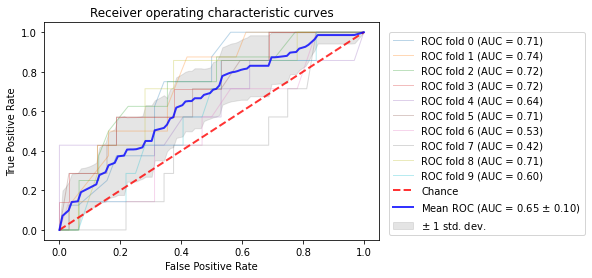

,score,mean,95% CI
0,AUC,0.65,"(0.45,0.85)"
1,accuracy,0.72,"(0.64,0.8)"
2,sensitivity,0.34,"(0,0.69)"
3,specificity,0.81,"(0.76,0.85)"
4,PPV,0.28,"(0.02,0.54)"
5,NPV,0.84,"(0.78,0.91)"


In [30]:
test_model(lr, X, y)

Using ```GridSearchCV``` with 10 folds:

In [37]:
class HashableDict(dict):
    def __hash__(self):
        return hash(tuple(sorted(self.items())))


In [44]:
lr = Pipeline([('Scaler', StandardScaler()),('LR',LogisticRegression(solver='liblinear', max_iter=10000, random_state=SEED))])

params_lr = {'LR__penalty': ['l1','l2'], 'LR__C': [0.001,0.002,0.005,0.01,0.1,1,10,100], 
          'LR__class_weight': [{1:0.5},{1:1},{1:5},{1:10},{1:15},{1:20}]}



gs_lr = BayesSearchCV(lr, params_lr, n_iter=100, scoring='roc_auc', cv=10, n_jobs=2, random_state=1997)
_ = gs_lr.fit(X,y)

In [45]:
gs_lr.best_params_

OrderedDict([('LR__C', 0.00048426655030173416),
             ('LR__class_weight', {1: 15}),
             ('LR__penalty', 'l2')])

In [46]:
test_model_bootstrap(gs_lr.best_estimator_, X, y)

,score,mean,95% CI
0,AUC,0.75,"(0.69,0.8)"
1,accuracy,0.75,"(0.72,0.78)"
2,sensitivity,0.51,"(0.37,0.65)"
3,specificity,0.80,"(0.79,0.81)"
4,PPV,0.37,"(0.28,0.46)"
5,NPV,0.88,"(0.84,0.92)"


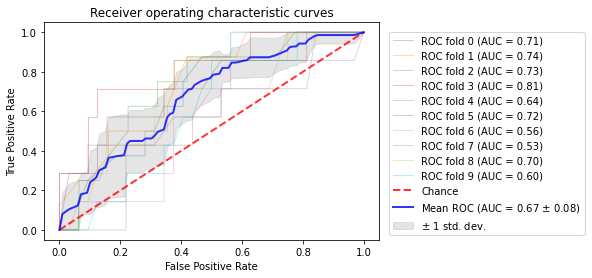

,score,mean,95% CI
0,AUC,0.68,"(0.51,0.84)"
1,accuracy,0.72,"(0.64,0.81)"
2,sensitivity,0.37,"(0,0.78)"
3,specificity,0.81,"(0.77,0.84)"
4,PPV,0.29,"(0.01,0.56)"
5,NPV,0.85,"(0.77,0.93)"


In [47]:
test_model(gs_lr.best_estimator_, X, y)

### Random Forest

In [66]:
rf = RandomForestClassifier()

params_rf = {'n_estimators': [10,15,20,30,50,80,100], 'max_depth': [None,2,3,5], 
          'class_weight': [{1:0.5},{1:1},{1:5},{1:10},{1:15},{1:20}]}

gs = GridSearchCV(rf, params_rf, scoring='roc_auc', cv=10, verbose=1, n_jobs=2)
_ = gs.fit(X,y)

Fitting 10 folds for each of 168 candidates, totalling 1680 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 164 tasks      | elapsed:    6.1s
[Parallel(n_jobs=2)]: Done 764 tasks      | elapsed:   30.2s
[Parallel(n_jobs=2)]: Done 1680 out of 1680 | elapsed:  1.1min finished


In [67]:
gs.best_params_

{'class_weight': {1: 0.5}, 'max_depth': 2, 'n_estimators': 20}

In [68]:
test_model_bootstrap(gs.best_estimator_, X, y)

,score,mean,95% CI
0,AUC,0.77,"(0.72,0.81)"
1,accuracy,0.75,"(0.72,0.78)"
2,sensitivity,0.54,"(0.41,0.68)"
3,specificity,0.80,"(0.78,0.82)"
4,PPV,0.38,"(0.3,0.46)"
5,NPV,0.88,"(0.84,0.93)"


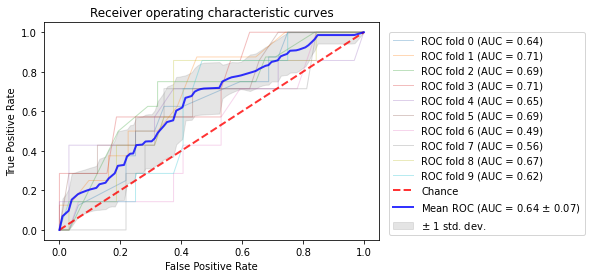

,score,mean,95% CI
0,AUC,0.64,"(0.51,0.78)"
1,accuracy,0.70,"(0.62,0.79)"
2,sensitivity,0.30,"(0,0.66)"
3,specificity,0.80,"(0.74,0.85)"
4,PPV,0.24,"(0,0.49)"
5,NPV,0.83,"(0.76,0.9)"


In [24]:
test_model(gs.best_estimator_, X, y)

**Feature importances**

In [25]:
importances = gs.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in gs.best_estimator_.estimators_], axis=0)

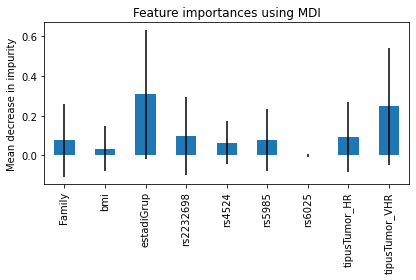

In [26]:
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

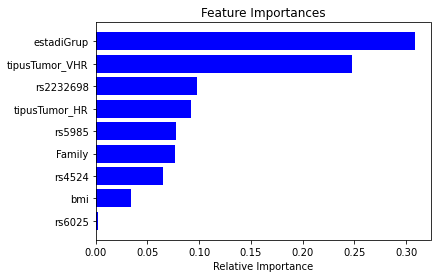

In [27]:
features = X.columns
importances = gs.best_estimator_.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### SVM

In [32]:
svm = Pipeline([('Scaler', StandardScaler()),('SVM', SVC(probability=True))])

params_svm = {'SVM__C': [0.001,0.01,0.1,1,10], 'SVM__kernel': ['poly','rbf'], 'SVM__degree': [2,3],
          'SVM__class_weight': [{1:0.5},{1:1},{1:5},{1:10},{1:15},{1:20}]}

gs_svm = GridSearchCV(svm, params_svm, scoring='roc_auc', cv=10, verbose=1, n_jobs=2)
_ = gs_svm.fit(X,y)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 164 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done 764 tasks      | elapsed:   18.8s
[Parallel(n_jobs=2)]: Done 1200 out of 1200 | elapsed:   32.5s finished


In [33]:
gs_svm.best_params_

{'SVM__C': 0.01,
 'SVM__class_weight': {1: 5},
 'SVM__degree': 2,
 'SVM__kernel': 'rbf'}

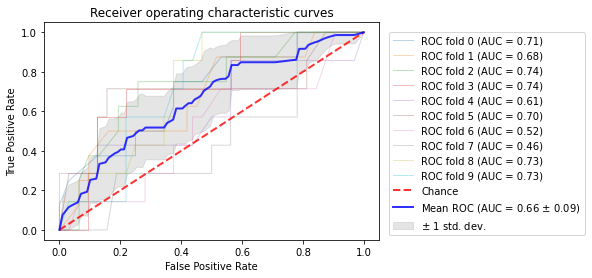

,score,mean,95% CI
0,AUC,0.66,"(0.47,0.85)"
1,accuracy,0.73,"(0.67,0.79)"
2,sensitivity,0.39,"(0.04,0.75)"
3,specificity,0.81,"(0.76,0.85)"
4,PPV,0.31,"(0.1,0.51)"
5,NPV,0.85,"(0.79,0.92)"


In [34]:
test_model(gs_svm.best_estimator_, X, y)

### 1.2) Using all the rows

Rows with NaNs are not considered.

In [48]:
data = pd.read_csv(path + 'data_TiC_Onco_large.csv')
X = data[data.columns.difference(['id','excluido','VTE','khorana'])]
y = data['VTE']
khorana = data['khorana']

X.shape, y.shape

((405, 9), (405,))

In [49]:
y.value_counts() # 320, 71

0    327
1     78
Name: VTE, dtype: int64

### Khorana score

In [50]:
test_khorana(khorana, y)

AUC:  52.67
Accuracy (%): 70.86
Sensivity (%): 23.08
Specificity (%): 82.26
PPV (%): 23.68
NPV (%): 81.76


In [51]:
test_khorana_bootstrap(khorana, y)

,score,mean,95% CI
0,AUC,0.53,"(0.48,0.58)"
1,accuracy,0.71,"(0.67,0.75)"
2,sensitivity,0.23,"(0.14,0.33)"
3,specificity,0.82,"(0.79,0.86)"
4,PPV,0.24,"(0.14,0.34)"
5,NPV,0.82,"(0.77,0.86)"


### Baseline model (Logistic Regression)

In [52]:
lr = LogisticRegression(solver='liblinear', random_state=1997)

In [53]:
test_model_bootstrap(lr, X, y)

,score,mean,95% CI
0,AUC,0.73,"(0.67,0.79)"
1,accuracy,0.74,"(0.71,0.77)"
2,sensitivity,0.48,"(0.34,0.62)"
3,specificity,0.80,"(0.79,0.82)"
4,PPV,0.36,"(0.28,0.44)"
5,NPV,0.87,"(0.82,0.91)"


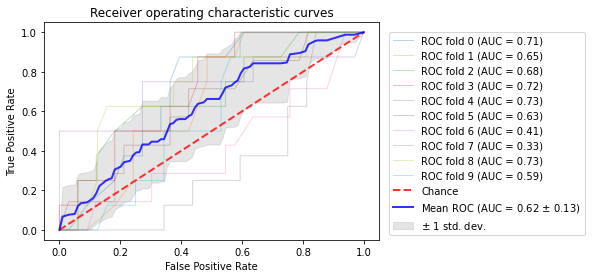

,score,mean,95% CI
0,AUC,0.62,"(0.35,0.88)"
1,accuracy,0.71,"(0.61,0.81)"
2,sensitivity,0.29,"(0,0.68)"
3,specificity,0.80,"(0.76,0.85)"
4,PPV,0.25,"(0,0.54)"
5,NPV,0.83,"(0.74,0.91)"


In [54]:
test_model(lr, X, y)

Using ```GridSearchCV``` with 10 folds:

In [75]:
lr = Pipeline([('Scaler', StandardScaler()),('LR',LogisticRegression(solver='liblinear', max_iter=10000))])

params_lr = {'LR__penalty': ['l1','l2'], 'LR__C': [0.001,0.005,0.01,0.05,0.1,1,10,100], 
          'LR__class_weight': [{1:0.5},{1:1},{1:5},{1:10},{1:15},{1:20},{1:25}]}

gs_lr = GridSearchCV(lr, params_lr, scoring='roc_auc', cv=10, verbose=1, n_jobs=2)
_ = gs_lr.fit(X,y)

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 956 tasks      | elapsed:    5.1s
[Parallel(n_jobs=2)]: Done 1120 out of 1120 | elapsed:    5.9s finished


In [76]:
gs_lr.best_params_

{'LR__C': 0.01, 'LR__class_weight': {1: 20}, 'LR__penalty': 'l1'}

In [77]:
test_model_bootstrap(gs_lr.best_estimator_, X, y)

,score,mean,95% CI
0,AUC,0.69,"(0.62,0.77)"
1,accuracy,0.75,"(0.67,0.82)"
2,sensitivity,0.39,"(0.1,0.68)"
3,specificity,0.83,"(0.69,0.97)"
4,PPV,0.35,"(0.15,0.56)"
5,NPV,0.85,"(0.8,0.9)"


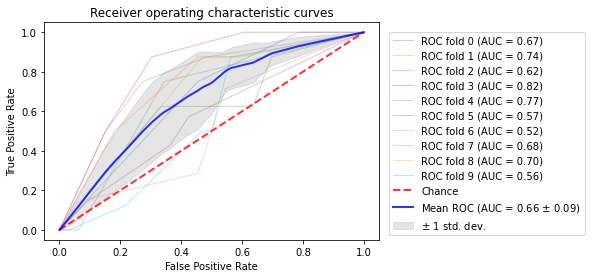

,score,mean,95% CI
0,AUC,0.66,"(0.48,0.85)"
1,accuracy,0.74,"(0.63,0.85)"
2,sensitivity,0.32,"(0,0.75)"
3,specificity,0.84,"(0.65,1)"
4,PPV,0.29,"(0.03,0.56)"
5,NPV,0.84,"(0.77,0.91)"


In [51]:
test_model(gs_lr.best_estimator_, X, y)

### Random Forest

In [52]:
rf = RandomForestClassifier()

params_rf = {'n_estimators': [10,15,20,30,50,80,100], 'max_depth': [None,2,3,5], 
          'class_weight': [{1:0.5},{1:1},{1:5},{1:10},{1:15},{1:20}]}

gs = GridSearchCV(rf, params_rf, scoring='roc_auc', cv=10, verbose=1, n_jobs=2)
_ = gs.fit(X,y)

Fitting 10 folds for each of 168 candidates, totalling 1680 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  82 tasks      | elapsed:    7.9s
[Parallel(n_jobs=2)]: Done 382 tasks      | elapsed:   37.9s
[Parallel(n_jobs=2)]: Done 882 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done 1582 tasks      | elapsed:  2.7min
[Parallel(n_jobs=2)]: Done 1677 out of 1680 | elapsed:  2.9min remaining:    0.2s
[Parallel(n_jobs=2)]: Done 1680 out of 1680 | elapsed:  2.9min finished


In [53]:
gs.best_params_

{'class_weight': {1: 10}, 'max_depth': 2, 'n_estimators': 10}

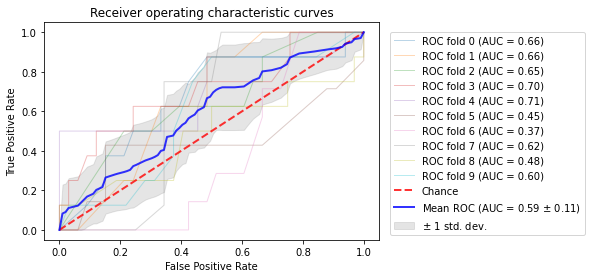

,score,mean,95% CI
0,AUC,0.59,"(0.37,0.81)"
1,accuracy,0.70,"(0.61,0.78)"
2,sensitivity,0.26,"(0,0.64)"
3,specificity,0.80,"(0.75,0.85)"
4,PPV,0.22,"(0,0.49)"
5,NPV,0.82,"(0.75,0.9)"


In [54]:
test_model(gs.best_estimator_, X, y)

### SVM

In [55]:
svm = Pipeline([('Scaler', StandardScaler()),('SVM', SVC(probability=True))])

params_svm = {'SVM__C': [0.001,0.01,0.1,1,10], 'SVM__kernel': ['poly','rbf'], 'SVM__degree': [2,3],
          'SVM__class_weight': [{1:0.5},{1:1},{1:5},{1:10},{1:15},{1:20}]}

gs_svm = GridSearchCV(svm, params_svm, scoring='roc_auc', cv=10, verbose=1, n_jobs=2)
_ = gs_svm.fit(X,y)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 164 tasks      | elapsed:    3.7s
[Parallel(n_jobs=2)]: Done 764 tasks      | elapsed:   19.3s
[Parallel(n_jobs=2)]: Done 1200 out of 1200 | elapsed:   34.3s finished


In [56]:
gs_svm.best_params_

{'SVM__C': 0.001,
 'SVM__class_weight': {1: 0.5},
 'SVM__degree': 2,
 'SVM__kernel': 'rbf'}

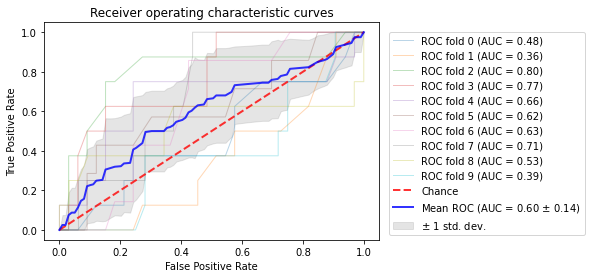

,score,mean,95% CI
0,AUC,0.59,"(0.31,0.88)"
1,accuracy,0.71,"(0.59,0.83)"
2,sensitivity,0.31,"(0,0.77)"
3,specificity,0.81,"(0.75,0.86)"
4,PPV,0.25,"(0,0.6)"
5,NPV,0.83,"(0.73,0.94)"


In [57]:
test_model(gs_svm.best_estimator_, X, y)

## 2) Considering all the variables in table 1

<img src="images/table1.png" alt="" width="250"/>

- Missing ```A1 blood group``` in the data. I have used genes *rs8176729, rs7853989, rs8176749, rs8176750* instead.

### 2.1) Only rows where ```excluido==0```

In [55]:
data = pd.read_excel(path + 'Oncothromb_bbddMarzo2018.xlsx')
X, y, khorana = get_data(data, exclude=True)

Initial shape: (408, 27)
Features shape: (383, 29)
Target shape: (383,)

Number of No-VTE (0) and VTE (1): [310  73]


In [56]:
X.head()

,Family,bmi,diabetesM,dislip,edatDx,estadiGrup_III,estadiGrup_IV,estadiGrup_I_II,fumador,hemoglobina,hta_desc,leucocits,plaquetes,rs121909548,rs1799963,rs1801020,rs2232698,rs4524,rs5985,rs6025,rs8176719,rs8176749,rs8176750,sexe,tipusTumor_colon,tipusTumor_esofago,tipusTumor_estomago,tipusTumor_pancreas,tipusTumor_pulmon
0,0,1,0,0,50,0,1,0,1,13.0,0,10900,203000,0,0,0,0,1,1,0,2,0,0,0,0,1,0,0,0
1,0,0,0,0,71,0,0,1,0,14.0,1,7000,245000,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,1,68,0,1,0,1,12.4,1,7700,194000,0,0,1,0,2,0,0,1,0,0,0,0,0,0,0,1
3,0,0,1,1,71,0,1,0,1,10.4,1,8600,284000,0,0,0,0,2,0,0,1,0,1,0,1,0,0,0,0
4,0,1,0,0,59,0,1,0,0,12.3,1,8800,254000,0,0,1,0,2,0,0,2,0,0,0,1,0,0,0,0


In [109]:
print_summary(X,y)


                        Variable  VTE (n)  VTE (%)  No-VTE (n)  No-VTE (%)
0                         Family        6      8.2          11         3.5
1                            bmi       37     50.7         139        44.8
2                      diabetesM       12     16.4          61        19.7
3                         dislip       29     39.7         103        33.2
4                         edatDx       64   1130.4          64      1040.7
5                 estadiGrup_III       19     26.0         116        37.4
6                  estadiGrup_IV       49     67.1         129        41.6
7                estadiGrup_I_II        5      6.8          65        21.0
8                fumador - nunca       52     71.2         244        78.7
9            fumador - exfumador       21     28.8          66        21.3
10             fumador - fumador        0      0.0           0         0.0
11           hemoglobina <100g/L        5      6.8          17         5.5
12                      

### Khorana score

In [57]:
test_khorana(khorana, y)

AUC:  52.61
Accuracy (%): 70.76
Sensivity (%): 23.29
Specificity (%): 81.94
PPV (%): 23.29
NPV (%): 81.94


### Baseline model (Logistic Regression)

In [60]:
lr = LogisticRegression(solver='liblinear', random_state=1997)

In [61]:
test_model_bootstrap(lr, X, y)

,score,mean,95% CI
0,AUC,0.56,"(0.48,0.64)"
1,accuracy,0.70,"(0.67,0.73)"
2,sensitivity,0.29,"(0.18,0.39)"
3,specificity,0.80,"(0.79,0.81)"
4,PPV,0.25,"(0.17,0.33)"
5,NPV,0.83,"(0.78,0.87)"


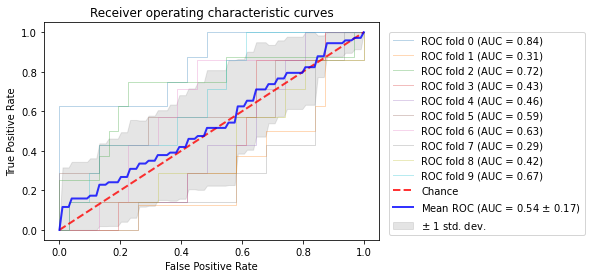

,score,mean,95% CI
0,AUC,0.54,"(0.19,0.88)"
1,accuracy,0.68,"(0.53,0.83)"
2,sensitivity,0.20,"(0,0.62)"
3,specificity,0.79,"(0.61,0.97)"
4,PPV,0.16,"(0,0.48)"
5,NPV,0.81,"(0.73,0.89)"


In [62]:
test_model(lr, X, y)

Using ```GridSearchCV``` with 10 folds:

In [63]:
lr = Pipeline([('Scaler', StandardScaler()),('LR',LogisticRegression(solver='liblinear', max_iter=10000))])

params_lr = {'LR__penalty': ['l1','l2'], 'LR__C': [0.001,0.005,0.01,0.05,0.1,1,10,100], 
          'LR__class_weight': [{1:0.5},{1:1},{1:5},{1:10},{1:15},{1:20},{1:25}]}

gs_lr = GridSearchCV(lr, params_lr, scoring='roc_auc', cv=10, verbose=1, n_jobs=2)
_ = gs_lr.fit(X,y)

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 330 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done 1120 out of 1120 | elapsed:   10.4s finished


In [64]:
gs_lr.best_params_

{'LR__C': 0.05, 'LR__class_weight': {1: 1}, 'LR__penalty': 'l1'}

In [65]:
test_model_bootstrap(gs_lr.best_estimator_, X, y)

,score,mean,95% CI
0,AUC,0.73,"(0.66,0.8)"
1,accuracy,0.78,"(0.72,0.84)"
2,sensitivity,0.47,"(0.29,0.65)"
3,specificity,0.85,"(0.75,0.95)"
4,PPV,0.43,"(0.32,0.54)"
5,NPV,0.87,"(0.83,0.91)"


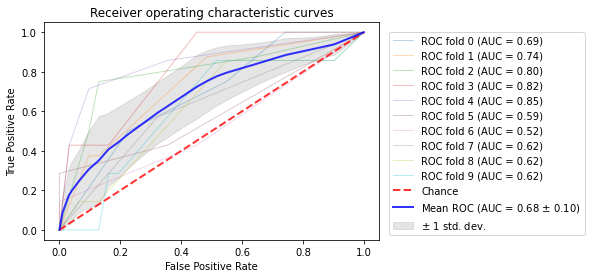

,score,mean,95% CI
0,AUC,0.69,"(0.48,0.89)"
1,accuracy,0.75,"(0.59,0.9)"
2,sensitivity,0.42,"(0,0.87)"
3,specificity,0.83,"(0.63,1)"
4,PPV,0.33,"(0,0.69)"
5,NPV,0.86,"(0.78,0.94)"


In [66]:
test_model(gs_lr.best_estimator_, X, y)

### Random Forest

In [8]:
rf = RandomForestClassifier()

params_rf = {'n_estimators': [20,50,80,100,120], 'max_depth': [None,2,3,5,7], 
          'class_weight': [{1:0.5},{1:1},{1:5},{1:10},{1:15},{1:20}]}

gs = GridSearchCV(rf, params_rf, scoring='roc_auc', cv=10, verbose=1, n_jobs=2)
_ = gs.fit(X,y)

Fitting 10 folds for each of 150 candidates, totalling 1500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    4.6s
[Parallel(n_jobs=2)]: Done 596 tasks      | elapsed:   40.8s
[Parallel(n_jobs=2)]: Done 1500 out of 1500 | elapsed:  1.7min finished


In [9]:
gs.best_params_

{'class_weight': {1: 1}, 'max_depth': 7, 'n_estimators': 50}

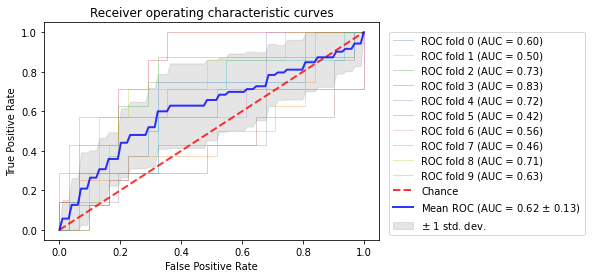

,score,mean,95% CI
0,AUC,0.62,"(0.36,0.87)"
1,accuracy,0.72,"(0.59,0.86)"
2,sensitivity,0.30,"(0.09,0.51)"
3,specificity,0.82,"(0.66,0.98)"
4,PPV,0.32,"(0.05,0.59)"
5,NPV,0.83,"(0.78,0.89)"


In [10]:
test_model(gs.best_estimator_, X, y)

**Feature importances**

In [11]:
importances = gs.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in gs.best_estimator_.estimators_], axis=0)

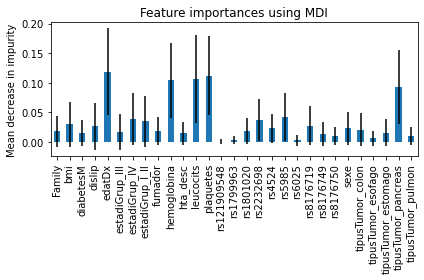

In [12]:
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

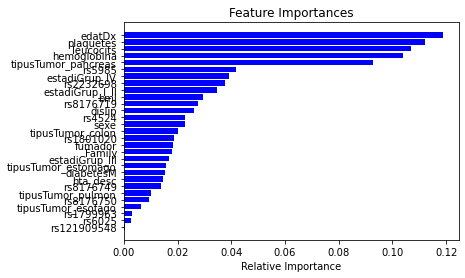

In [13]:
features = X.columns
importances = gs.best_estimator_.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### SVM

In [119]:
svm = Pipeline([('Scaler', StandardScaler()),('SVM', SVC(probability=True))])

params_svm = {'SVM__C': [0.001,0.01,0.1,1,10], 'SVM__kernel': ['poly','rbf'], 'SVM__degree': [2,3],
          'SVM__class_weight': [{1:0.5},{1:1},{1:5},{1:10},{1:15},{1:20}]}

gs_svm = GridSearchCV(svm, params_svm, scoring='roc_auc', cv=10, verbose=1, n_jobs=2)
_ = gs_svm.fit(X,y)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 300 tasks      | elapsed:    5.0s
[Parallel(n_jobs=2)]: Done 1200 out of 1200 | elapsed:   22.0s finished


In [120]:
gs_svm.best_params_

{'SVM__C': 0.001,
 'SVM__class_weight': {1: 1},
 'SVM__degree': 2,
 'SVM__kernel': 'rbf'}

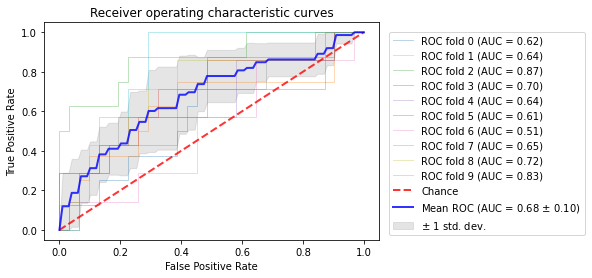

,score,mean,95% CI
0,AUC,0.68,"(0.48,0.88)"
1,accuracy,0.71,"(0.63,0.8)"
2,sensitivity,0.38,"(0.1,0.66)"
3,specificity,0.79,"(0.71,0.87)"
4,PPV,0.30,"(0.13,0.47)"
5,NPV,0.85,"(0.78,0.91)"


In [121]:
test_model(gs_svm.best_estimator_, X, y)

### 2.2) Considering all rows

In [67]:
data = pd.read_excel(path + 'Oncothromb_bbddMarzo2018.xlsx')
X, y, khorana = get_data(data, exclude=False)

Initial shape: (408, 27)
Features shape: (398, 29)
Target shape: (398,)

Number of No-VTE (0) and VTE (1): [320  78]


### Khorana score

In [123]:
test_khorana(khorana, y)

AUC:  52.63
Accuracy (%): 70.6
Sensivity (%): 23.08
Specificity (%): 82.19
PPV (%): 24.0
NPV (%): 81.42


### Baseline model (Logistic Regression)

In [68]:
lr = LogisticRegression(solver='liblinear', random_state=1997)

In [69]:
test_model_bootstrap(lr, X, y)

,score,mean,95% CI
0,AUC,0.55,"(0.47,0.63)"
1,accuracy,0.70,"(0.67,0.73)"
2,sensitivity,0.28,"(0.16,0.4)"
3,specificity,0.80,"(0.79,0.81)"
4,PPV,0.25,"(0.16,0.35)"
5,NPV,0.82,"(0.78,0.86)"


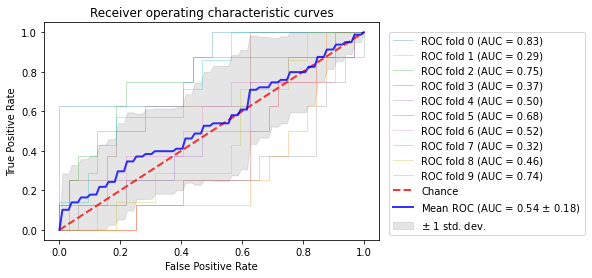

,score,mean,95% CI
0,AUC,0.54,"(0.18,0.91)"
1,accuracy,0.69,"(0.56,0.81)"
2,sensitivity,0.17,"(0,0.54)"
3,specificity,0.82,"(0.68,0.95)"
4,PPV,0.15,"(0,0.45)"
5,NPV,0.80,"(0.72,0.88)"


In [70]:
test_model(lr, X, y)

Using ```GridSearchCV``` with 10 folds:

In [71]:
lr = Pipeline([('Scaler', StandardScaler()),('LR',LogisticRegression(solver='liblinear', max_iter=10000))])

params_lr = {'LR__penalty': ['l1','l2'], 'LR__C': [0.001,0.005,0.01,0.05,0.1,1,10,100], 
          'LR__class_weight': [{1:0.5},{1:1},{1:5},{1:10},{1:15},{1:20},{1:25}]}

gs_lr = GridSearchCV(lr, params_lr, scoring='roc_auc', cv=10, verbose=1, n_jobs=2)
_ = gs_lr.fit(X,y)

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 540 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done 1120 out of 1120 | elapsed:    8.8s finished


In [72]:
gs_lr.best_params_

{'LR__C': 0.05, 'LR__class_weight': {1: 1}, 'LR__penalty': 'l1'}

In [73]:
test_model_bootstrap(gs_lr.best_estimator_, X, y)

,score,mean,95% CI
0,AUC,0.72,"(0.64,0.8)"
1,accuracy,0.76,"(0.71,0.82)"
2,sensitivity,0.43,"(0.2,0.67)"
3,specificity,0.84,"(0.74,0.95)"
4,PPV,0.39,"(0.25,0.53)"
5,NPV,0.87,"(0.82,0.91)"


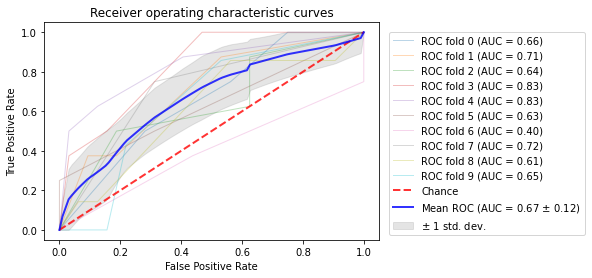

,score,mean,95% CI
0,AUC,0.67,"(0.44,0.9)"
1,accuracy,0.74,"(0.63,0.84)"
2,sensitivity,0.43,"(0.02,0.85)"
3,specificity,0.81,"(0.63,0.99)"
4,PPV,0.32,"(0.04,0.6)"
5,NPV,0.86,"(0.79,0.92)"


In [74]:
test_model(gs_lr.best_estimator_, X, y)

### Random Forest

In [129]:
rf = RandomForestClassifier()

params_rf = {'n_estimators': [10,15,20,30,50,80,100], 'max_depth': [None,2,3,5], 
          'class_weight': [{1:0.5},{1:1},{1:5},{1:10},{1:15},{1:20}]}

gs = GridSearchCV(rf, params_rf, scoring='roc_auc', cv=10, verbose=1, n_jobs=2)
_ = gs.fit(X,y)

Fitting 10 folds for each of 168 candidates, totalling 1680 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 164 tasks      | elapsed:    6.4s
[Parallel(n_jobs=2)]: Done 764 tasks      | elapsed:   32.5s
[Parallel(n_jobs=2)]: Done 1680 out of 1680 | elapsed:  1.2min finished


In [130]:
gs.best_params_

{'class_weight': {1: 0.5}, 'max_depth': 3, 'n_estimators': 15}

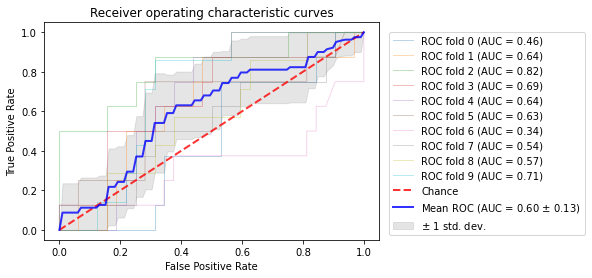

,score,mean,95% CI
0,AUC,0.60,"(0.35,0.86)"
1,accuracy,0.65,"(0.52,0.78)"
2,sensitivity,0.13,"(0,0.42)"
3,specificity,0.78,"(0.64,0.91)"
4,PPV,0.11,"(0,0.37)"
5,NPV,0.78,"(0.71,0.86)"


In [131]:
test_model(gs.best_estimator_, X, y)

### SVM

In [132]:
svm = Pipeline([('Scaler', StandardScaler()),('SVM', SVC(probability=True))])

params_svm = {'SVM__C': [0.001,0.01,0.1,1,10], 'SVM__kernel': ['poly','rbf'], 'SVM__degree': [2,3],
          'SVM__class_weight': [{1:0.5},{1:1},{1:5},{1:10},{1:15},{1:20}]}

gs_svm = GridSearchCV(svm, params_svm, scoring='roc_auc', cv=10, verbose=1, n_jobs=2)
_ = gs_svm.fit(X,y)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 300 tasks      | elapsed:    5.2s
[Parallel(n_jobs=2)]: Done 1200 out of 1200 | elapsed:   24.0s finished


In [133]:
gs_svm.best_params_

{'SVM__C': 0.001,
 'SVM__class_weight': {1: 5},
 'SVM__degree': 2,
 'SVM__kernel': 'rbf'}

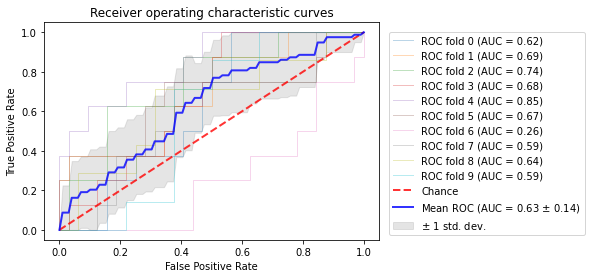

,score,mean,95% CI
0,AUC,0.63,"(0.34,0.92)"
1,accuracy,0.68,"(0.58,0.78)"
2,sensitivity,0.23,"(0,0.61)"
3,specificity,0.79,"(0.64,0.95)"
4,PPV,0.17,"(0,0.44)"
5,NPV,0.81,"(0.75,0.88)"


In [134]:
test_model(gs_svm.best_estimator_, X, y)

In [94]:
SEED = 1135
class_weight = {1:1}

base_models = [
          ('LR', LogisticRegression(solver='liblinear', max_iter=1000, random_state=SEED)), 
          ('RF', RandomForestClassifier(random_state=SEED, class_weight=class_weight)),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier(class_weight=class_weight)),
          ('SVM', SVC(probability=True, random_state=SEED, class_weight=class_weight)), 
          ('AB', AdaBoostClassifier(random_state=SEED)),
          ('GBM', GradientBoostingClassifier(random_state=SEED)),
          ('ET', ExtraTreesClassifier(random_state=SEED, class_weight=class_weight)),
          ('LGB', LGBMClassifier(class_weight=class_weight, random_state=SEED)),
#           ('XGB', XGBClassifier(random_state=SEED))
        ]

In [95]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler_name = 'standard'
  
if scaler_name == 'standard':
    scaler = StandardScaler()
elif scaler_name =='minmax':
    scaler = MinMaxScaler()

pipelines = []
for name, model in base_models:
  pipelines.append((name  , Pipeline([('Scaler', scaler),(name,model)])))

In [96]:
final = run_exps(pipelines, X, y)
bootstrap_df, results = results_bootstrap(final)

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


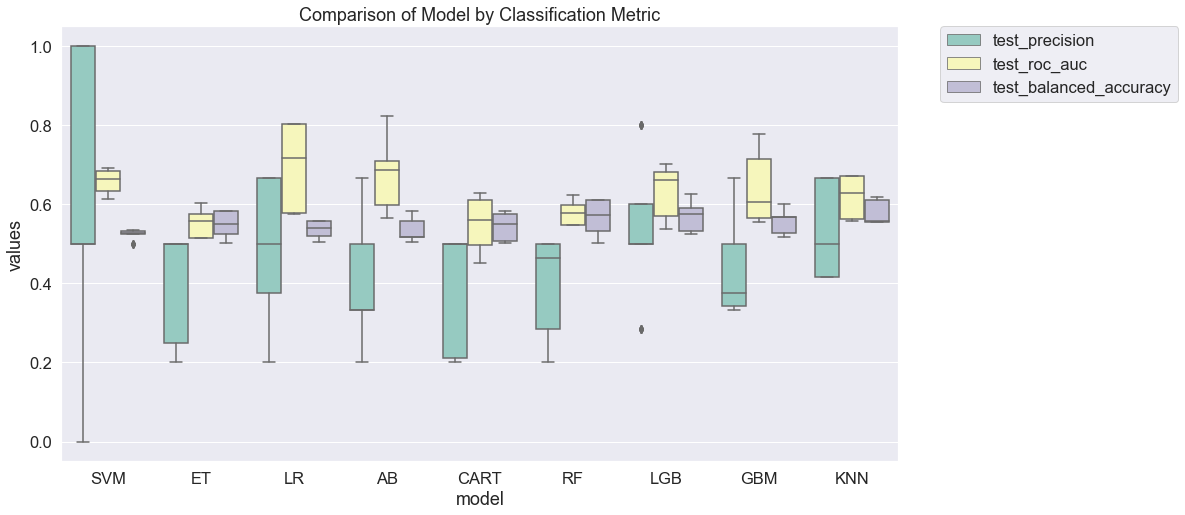

In [97]:
plot_performances(results)

In [98]:
tabulate_results(bootstrap_df, results)

test_roc_auc           test_balanced_accuracy           test_precision  \
              mean       std                   mean       std           mean   
model                                                                          
AB        0.677920  0.084655               0.531538  0.026992       0.391333   
CART      0.545042  0.061453               0.542278  0.030964       0.379000   
ET        0.556901  0.035020               0.545349  0.030040       0.393000   
GBM       0.641216  0.083995               0.560411  0.029466       0.430000   
KNN       0.616197  0.045052               0.580162  0.028191       0.541905   
LGB       0.628462  0.066765               0.571521  0.037322       0.539143   
LR        0.685548  0.092065               0.537831  0.020791       0.487333   
RF        0.577453  0.025413               0.565231  0.042832       0.392857   
SVM       0.655423  0.028052               0.526134  0.011341       0.640000   

                 
            std  
model            
AB     0.145657  
CART   0.136685  
ET     0.128575  
GBM    0.112763  
KNN    0.102246  
LGB    0.168582  
LR     0.150869  
RF     0.125348  
SVM    0.350510

In [ ]:
clf = Pipeline([('Scaler', MinMaxScaler()),('LR',LogisticRegression())])
clf.fit(X_train, y_train)

Pipeline(steps=[('Scaler', MinMaxScaler()), ('LR', LogisticRegression())])

AUC score (train): 0.7716
AUC score (test): 0.7331


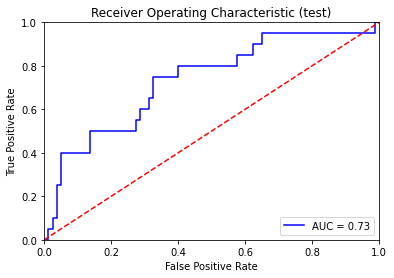


Accuracy in train set (%): 80.2
Accuracy in test set (%): 80.0

=====Train set=====
[[236   4]
 [ 55   3]]

Sensivity (%): 5.17
Specificity (%): 98.33
Precision (%): 42.86
NPV (%): 81.10000000000001

=====Test set=====
[[78  2]
 [18  2]]

Sensivity (%): 10.0
Specificity (%): 97.5
Precision (%): 50.0
NPV (%): 81.25


In [ ]:
y_pred_train = clf.predict_proba(X_train)[:,1]
y_pred_test = clf.predict_proba(X_test)[:,1]

evaluate_model(y_train, y_pred_train, y_test, y_pred_test)

AUC score (train): 0.9821
AUC score (test): 0.6862


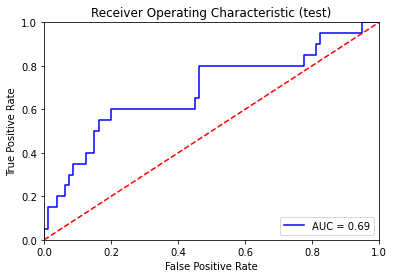


Accuracy in train set (%): 80.54
Accuracy in test set (%): 80.0

=====Train set=====
[[240   0]
 [ 58   0]]

Sensivity (%): 0.0
Specificity (%): 100.0
Precision (%): nan
NPV (%): 80.54

=====Test set=====
[[80  0]
 [20  0]]

Sensivity (%): 0.0
Specificity (%): 100.0
Precision (%): nan
NPV (%): 80.0


D:\pablo\master\TFM\utils.py:481: RuntimeWarning: invalid value encountered in longlong_scalars
  PPV = tp / (tp+fp)


In [ ]:
clf = Pipeline([('Scaler', StandardScaler()),('SVM',SVC(probability=True))])
clf.fit(X_train, y_train)

y_pred_train = clf.predict_proba(X_train)[:,1]
y_pred_test = clf.predict_proba(X_test)[:,1]

evaluate_model(y_train, y_pred_train, y_test, y_pred_test)

AUC score (train): 1.0
AUC score (test): 0.6404


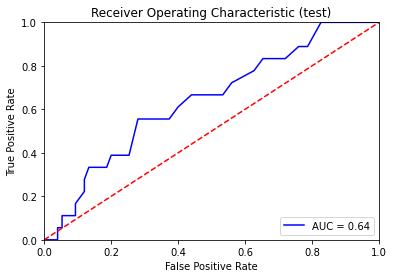


Accuracy in train set (%): 82.25
Accuracy in test set (%): 72.04

=====Train set=====
[[174  49]
 [  0  53]]

Sensivity (%): 100.0
Specificity (%): 78.03
Precision (%): 51.959999999999994
NPV (%): 100.0

=====Test set=====
[[60 15]
 [11  7]]

Sensivity (%): 38.89
Specificity (%): 80.0
Precision (%): 31.819999999999997
NPV (%): 84.50999999999999


In [ ]:
clf = Pipeline([('Scaler', StandardScaler()),('RF', RandomForestClassifier())])
clf.fit(X_train, y_train)

y_pred_train = clf.predict_proba(X_train)[:,1]
y_pred_test = clf.predict_proba(X_test)[:,1]

evaluate_model(y_train, y_pred_train, y_test, y_pred_test)